# **Capítulo 5: Redes neuronales convolucionales**

## Clasificación de dígitos manuscritos usando la base de datos MNIST

Comprobación de acceso a GPU

In [ ]:
import torch

# Si disponemos de GPU, la usamos
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Carga y preprocesado de datos

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

tam_batch = 64

# Datos de entrenamiento
train_dataset = datasets.MNIST(
    root='./datos', # Ruta donde se almacenarán los datos descargados
    train=True,     # Datos de entrenamiento
    transform=transforms.ToTensor(), # Conversión más normalización
    download=True   # Se descargan a la carpeta indicada en root
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # Dataset sobre el que iterar
    batch_size=tam_batch,
    shuffle=True    # Se mezclan los datos en cada época de entrenamiento
)

# Datos de test
test_dataset = datasets.MNIST(
    root='./datos', # Misma ruta que los datos de entrenamiento
    train=False,    # Datos de test
    transform=transforms.ToTensor() # Conversión más normalización
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=tam_batch,
    shuffle=False   # Los datos se evalúan siempre en el mismo orden
)

Visualización del aspecto de los datos

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de test: 10000
Tamaño de las imágenes: torch.Size([1, 28, 28])


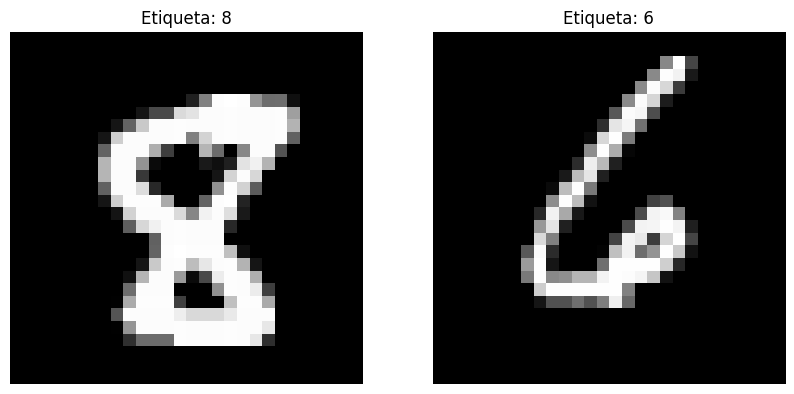

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset.data)}')
print(f'Tamaño del conjunto de test: {len(test_dataset.data)}')

# Obtenemos un lote o batch de imágenes de entrenamiento
imagenes, etiquetas = next(iter(train_loader))
print(f'Tamaño de las imágenes: {imagenes.shape[1:]}')

# Visualizamos las imágenes y etiquetas de un batch de entrenamiento
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2):
    axs[i].imshow(np.squeeze(imagenes[i]), cmap='gray')
    axs[i].set_title(f'Etiqueta: {etiquetas[i]}')
    axs[i].axis('off')
plt.show()

Implementación de la CNN a usar

In [4]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Capas
        # 1) Bloque extractor de características
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 2) Bloque clasificador de características
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(16 * 7 * 7, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)

        # Activaciones
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        y = self.lin3(x)
        return y

modelo = CNN()
# Si es posible, movemos el modelo a la GPU
modelo.to(dispositivo)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=784, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

Implementación de la función de entrenamiento

In [5]:
def epoca_train(
        modelo, train_loader, optimizador, func_perdida, dispositivo):
    epoca_perdidas = []
    # Iteramos sobre los datos de entrenamiento
    for i, (imagenes, etiquetas) in enumerate(train_loader):
        # Si es posible, transferimos los datos a la GPU
        imagenes = imagenes.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)
        # Ponemos los gradientes a cero
        optimizador.zero_grad()
        # Calculamos las salidas de la red neuronal
        # para las imágenes de entrada
        salidas = modelo(imagenes)
        # Calculamos la pérdida de la red neuronal
        perdida = func_perdida(salidas, etiquetas)
        # Calculamos los gradientes de la pérdida
        # respecto a los parámetros de la red neuronal
        perdida.backward()
        # Actualizamos los parámetros de la red neuronal
        # usando el algoritmo de optimización
        optimizador.step()
        # Añadimos a la lista de pérdidas la pérdida actual
        epoca_perdidas.append(perdida.item())
    # Calculamos la media de las pérdidas para una época
    return sum(epoca_perdidas) / len(epoca_perdidas)

Implementación de la función de test

In [ ]:
def epoca_test(modelo, test_loader, dispositivo):
    # Establecemos la red neuronal en modo de evaluación
    modelo.eval()
    # Desactivamos el cálculo de gradientes
    with torch.no_grad():
        correcto = 0
        total = 0
        # Iteramos sobre los datos de test
        for imagenes, etiquetas in test_loader:
            # Si es posible, transferimos los datos a la GPU
            imagenes = imagenes.to(dispositivo)
            etiquetas = etiquetas.to(dispositivo)
            # Calculamos las salidas de la red neuronal
            # para las imágenes de entrada
            salidas = modelo(imagenes)
            # Calculamos las probabilidades de las clases
            salidas = salidas.softmax(dim=1)
            # Obtenemos la clase con mayor probabilidad
            prediccion = salidas.argmax(dim=1)
            # Incrementamos el contador de imágenes procesadas
            total += etiquetas.size(0)
            # Incrementamos el contador de imágenes
            # clasificadas correctamente
            correcto += (prediccion == etiquetas).sum().item()
        # Calculamos la exactitud
        exactitud = 100 * correcto / total
    # Establecemos la red neuronal en modo entrenamiento
    modelo.train()
    return exactitud

Entrenamiento y test de la CNN con el conjunto de datos MNIST

In [6]:
import torch.optim as optim

# Learning rate de 0.001 por defecto
optimizador = optim.Adam(modelo.parameters())
# Función de pérdida de entropía cruzada
func_perdida = nn.CrossEntropyLoss()

# Histórico de valores de exactitud de entrenamiento
train_accs = []
# Histórico de valores de exactitud de test
test_accs = []
# Definimos el número de épocas de entrenamiento
epocas = 15
# Iteramos por cada época
for epoca in range(epocas):
    # Entrenamos la red neuronal por una época
    train_perdida = epoca_train(
        modelo, train_loader, optimizador, func_perdida, dispositivo)
    # Calculamos la exactitud para los datos de entrenamiento
    train_acc = epoca_test(modelo, train_loader, dispositivo)
    train_accs.append(train_acc)
    # Calculamos la exactitud para los datos de test
    test_acc = epoca_test(modelo, test_loader, dispositivo)
    test_accs.append(test_acc)
    # Sacamos los resultados por pantalla
    print(f'Época {epoca+1}/{epocas},\
    pérdida={train_perdida:.4f},\
    exactitud_train={train_acc:.2f}%,\
    exactitud_test={test_acc:.2f}%')
# Se ha completado el entrenamiento de la red neuronal
print('Fin del entrenamiento.')


Época 1/15,    pérdida=0.2914,    exactitud_train=97.31%,    exactitud_test=97.41%
Época 2/15,    pérdida=0.0799,    exactitud_train=98.21%,    exactitud_test=98.17%
Época 3/15,    pérdida=0.0561,    exactitud_train=98.06%,    exactitud_test=98.06%
Época 4/15,    pérdida=0.0445,    exactitud_train=98.71%,    exactitud_test=98.55%
Época 5/15,    pérdida=0.0365,    exactitud_train=99.08%,    exactitud_test=98.70%
Época 6/15,    pérdida=0.0299,    exactitud_train=99.26%,    exactitud_test=98.93%
Época 7/15,    pérdida=0.0256,    exactitud_train=99.34%,    exactitud_test=98.76%
Época 8/15,    pérdida=0.0235,    exactitud_train=99.33%,    exactitud_test=98.81%
Época 9/15,    pérdida=0.0177,    exactitud_train=99.44%,    exactitud_test=98.89%
Época 10/15,    pérdida=0.0165,    exactitud_train=99.39%,    exactitud_test=98.81%
Época 11/15,    pérdida=0.0140,    exactitud_train=99.45%,    exactitud_test=98.76%
Época 12/15,    pérdida=0.0131,    exactitud_train=99.72%,    exactitud_test=99.01%
É

Creación de una gráfica que muestre el progreso del rendimiento del modelo

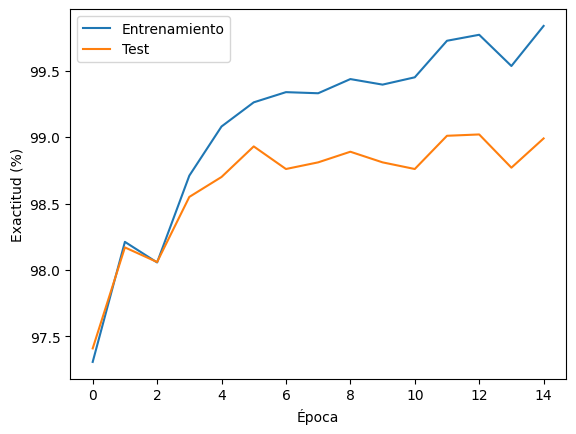

In [7]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.xlabel('Época')         # Eje X - Época
plt.ylabel('Exactitud (%)') # Eje Y - Exactitud
plt.legend(['Entrenamiento', 'Test'])
plt.show()

Guardado del modelo

In [8]:
torch.save(modelo.state_dict(), 'modelo_cap_5.pt')

Comprobación de la exactitud del modelo guardado sobre el conjunto de test

In [9]:
modelo = CNN()
modelo.load_state_dict(torch.load('modelo_cap_5.pt'))
modelo.to(dispositivo)
exactitud = epoca_test(modelo, test_loader, dispositivo)
print(f'Exactitud de test = {exactitud:.2f}%')

Exactitud de test = 98.99%
